In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [ ]:
import numpy as np
!pip install torch
import torch
import matplotlib.pyplot as plt
!pip install opencv-python-headless
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

For this pre-set example (and testing purposes), we are loading a pre-saved image of a bounding box from Planetary Computer, however, in practice this step would be obtained dynamically in real-time via Planetary Computer

In [ ]:
image = cv2.imread('images/vv.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

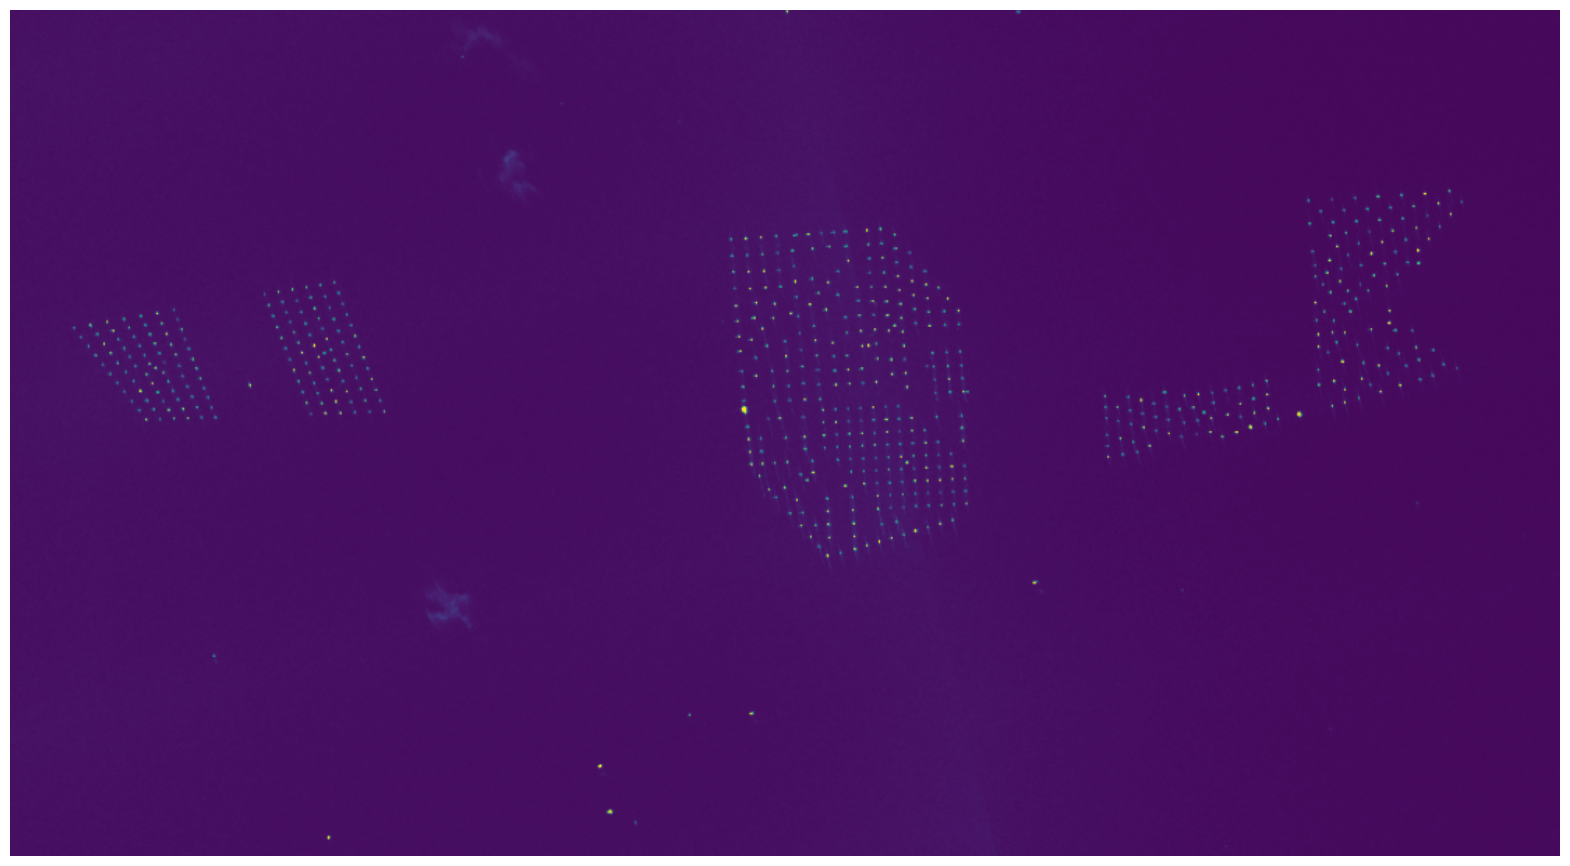

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
!pip install segment_anything
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())
print(masks[0]["area"])

13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
1004497


Show all the masks overlayed on the image.

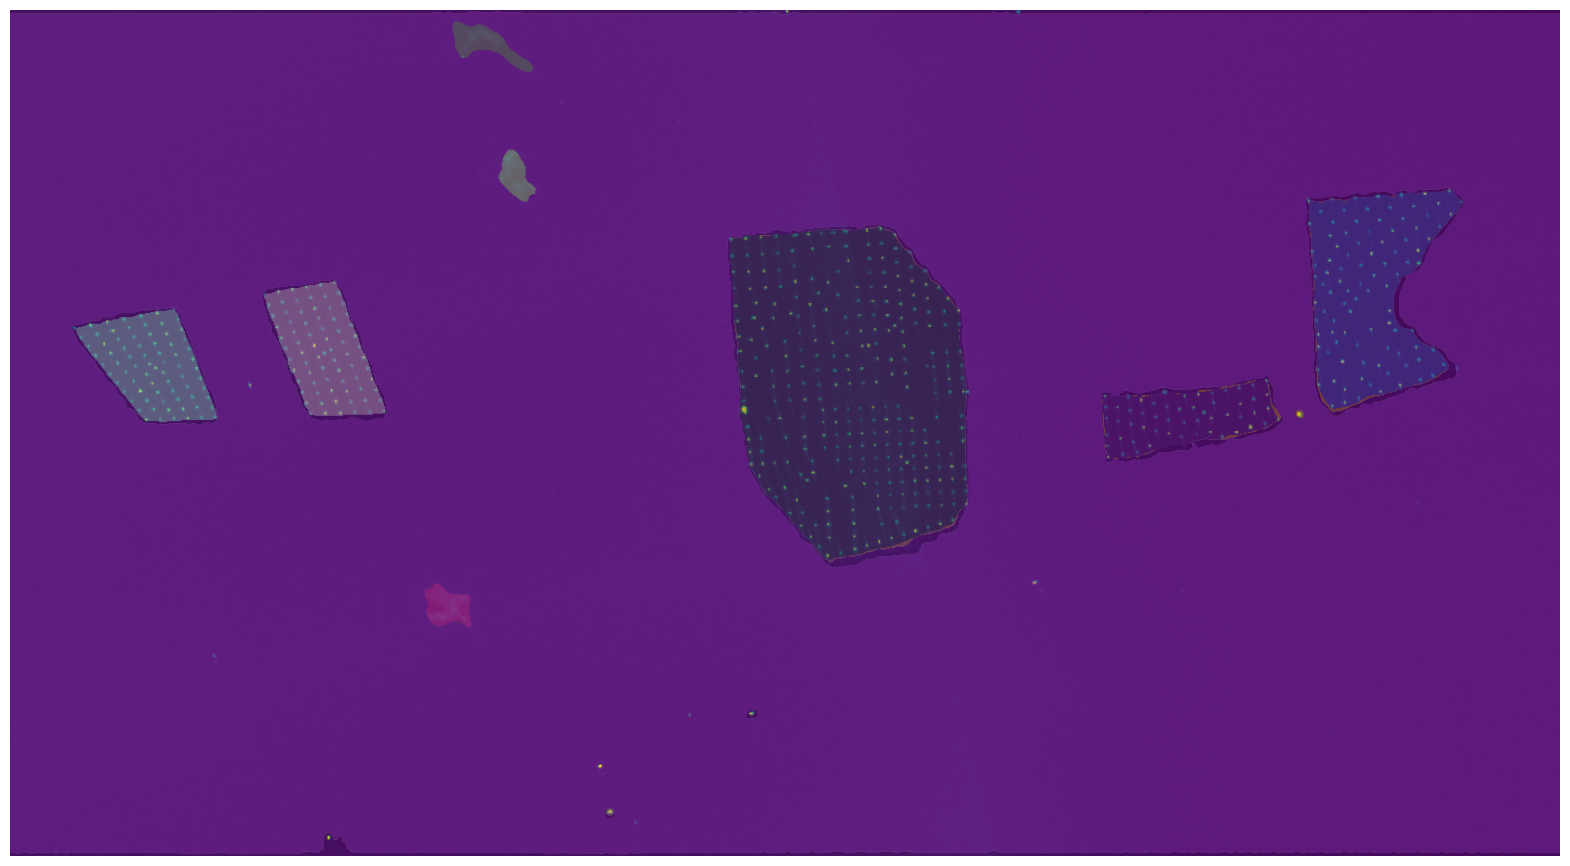

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

We will now save each individual bounding box as a separate image to run SAM on it again.

Warning: for some reason there's a visual glitch where artifacts of the above image are visible in the output... however in the saved file .png file of the bounding box, no such artifact is present (ignore it in the images below)

0 2 1433 778


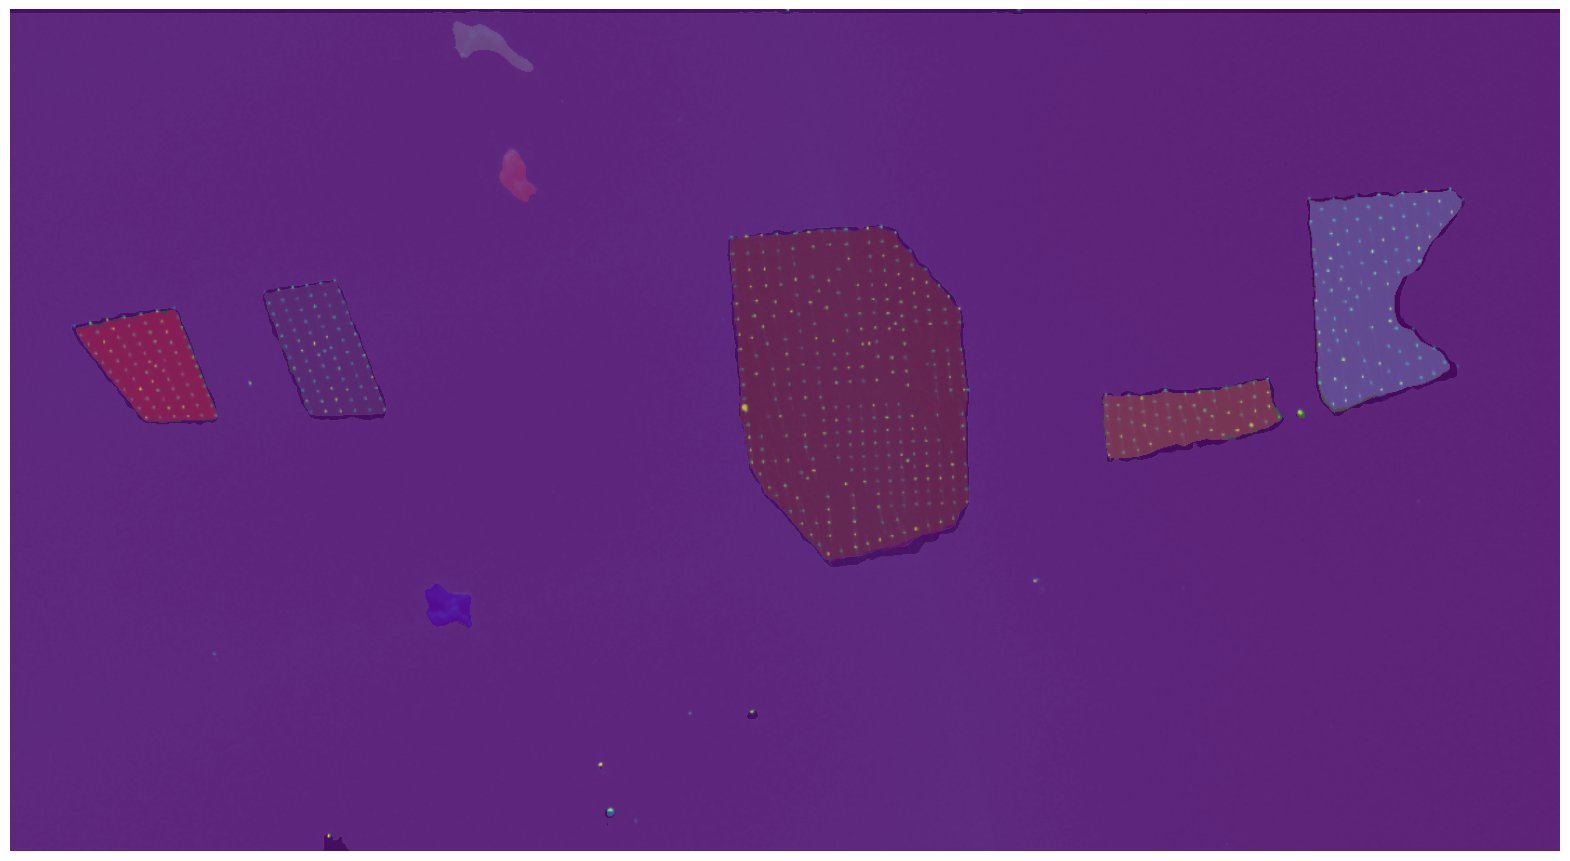

Image cropped and saved successfully!
666 202 219 307


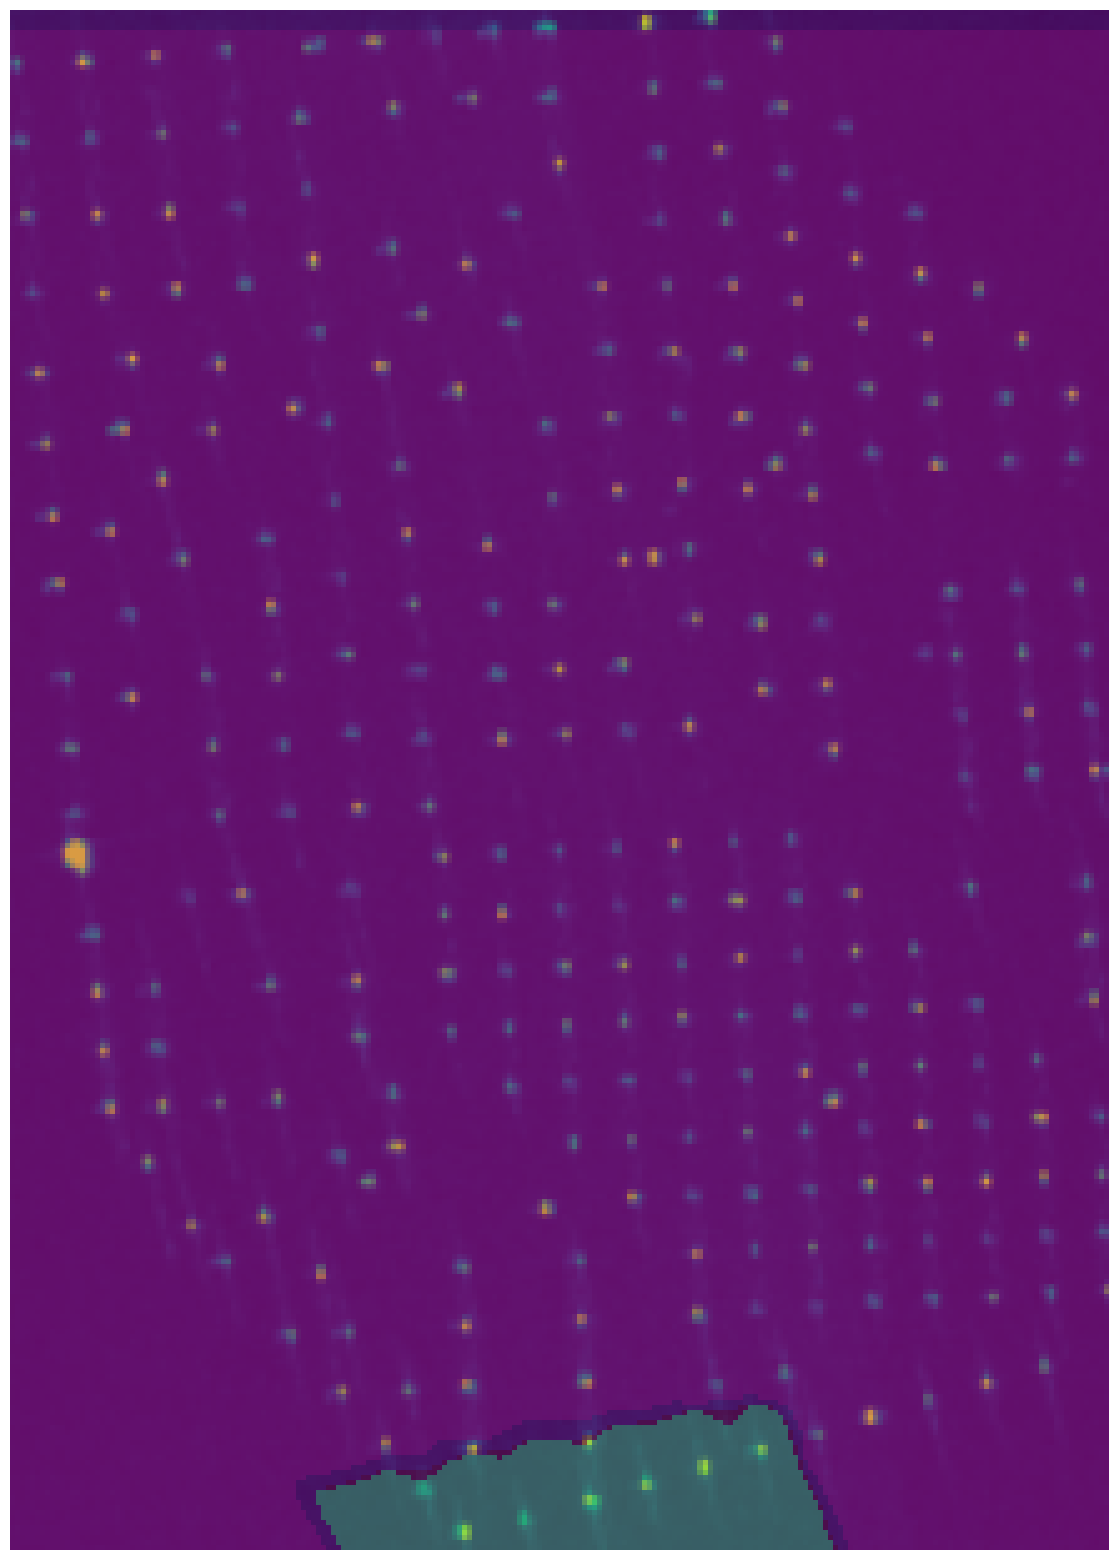

Image cropped and saved successfully!
61 278 129 102


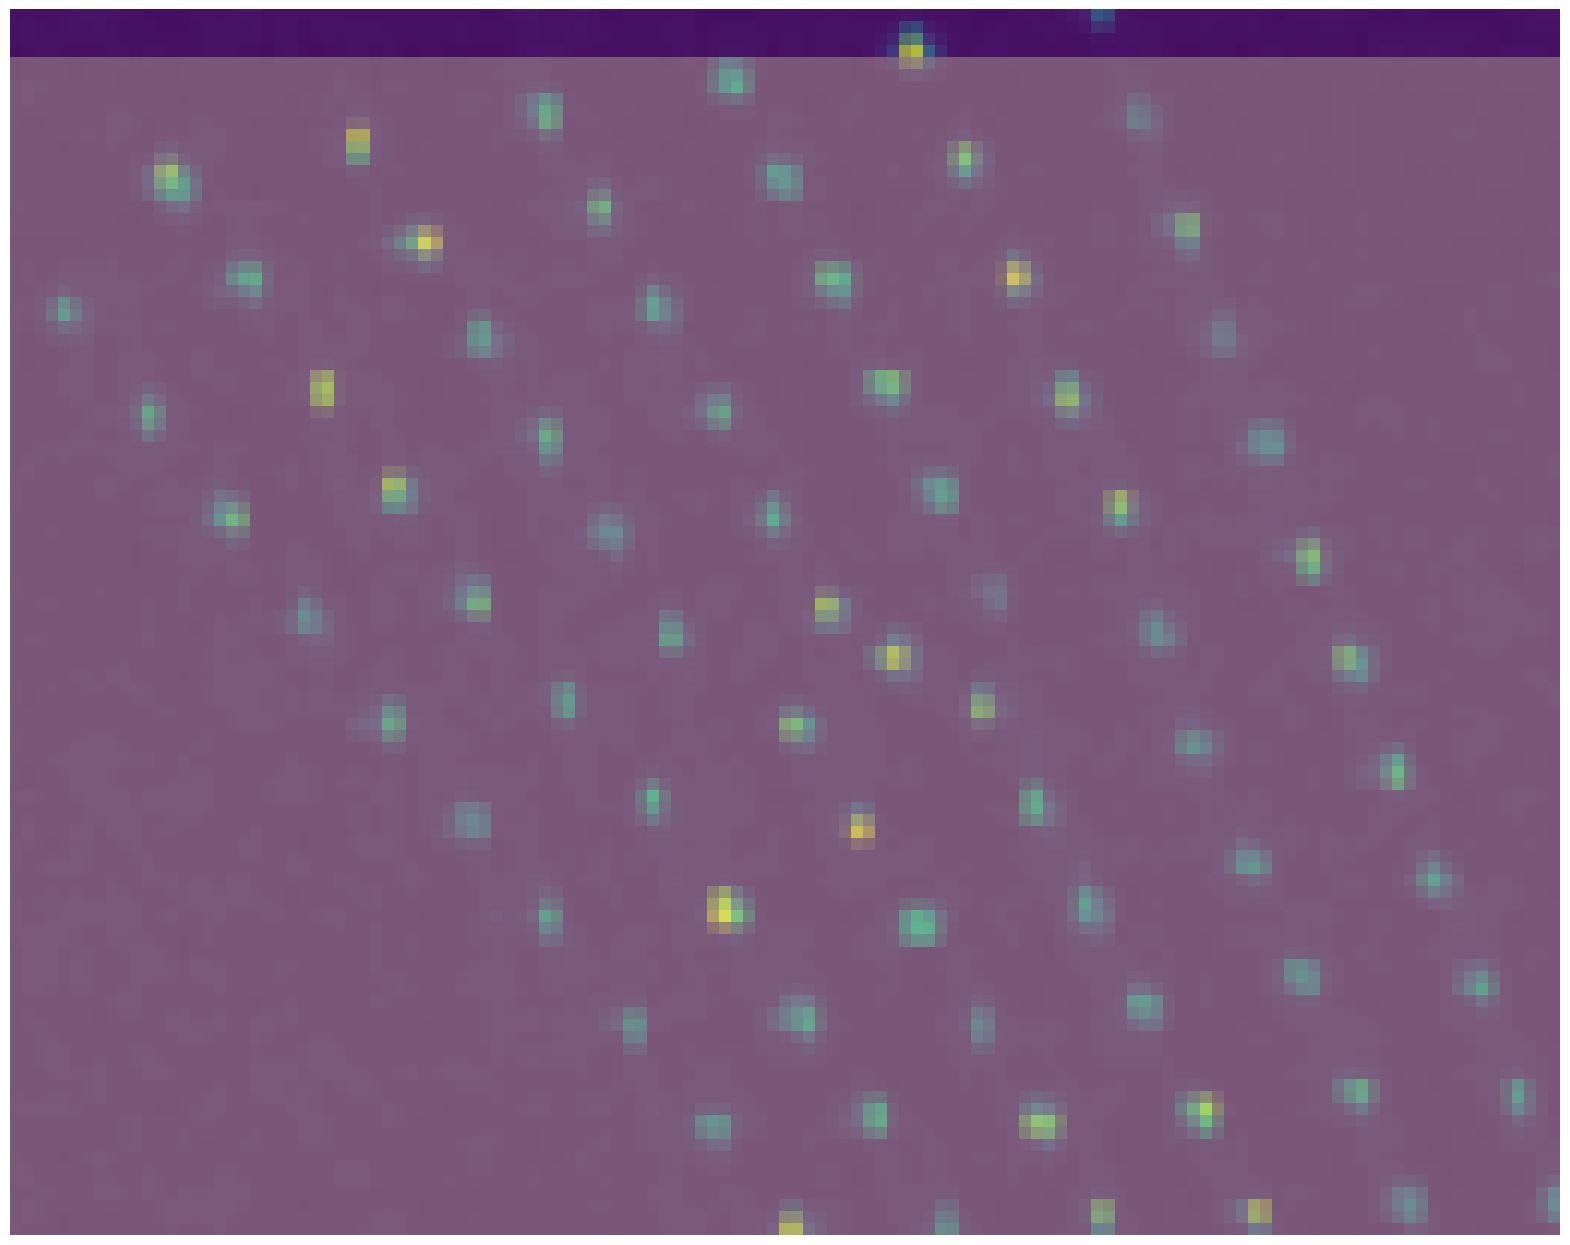

Image cropped and saved successfully!
61 253 284 128


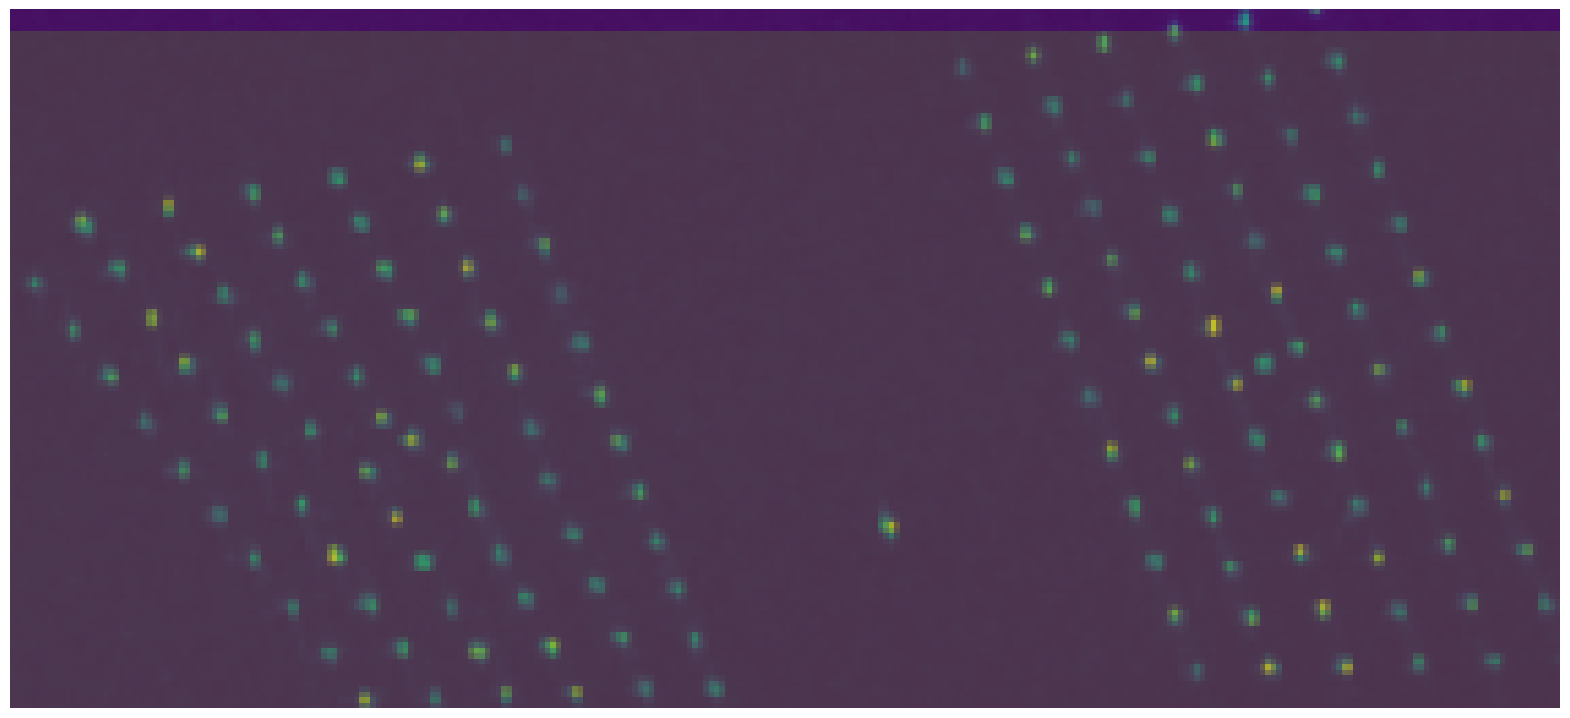

Image cropped and saved successfully!
235 252 111 123


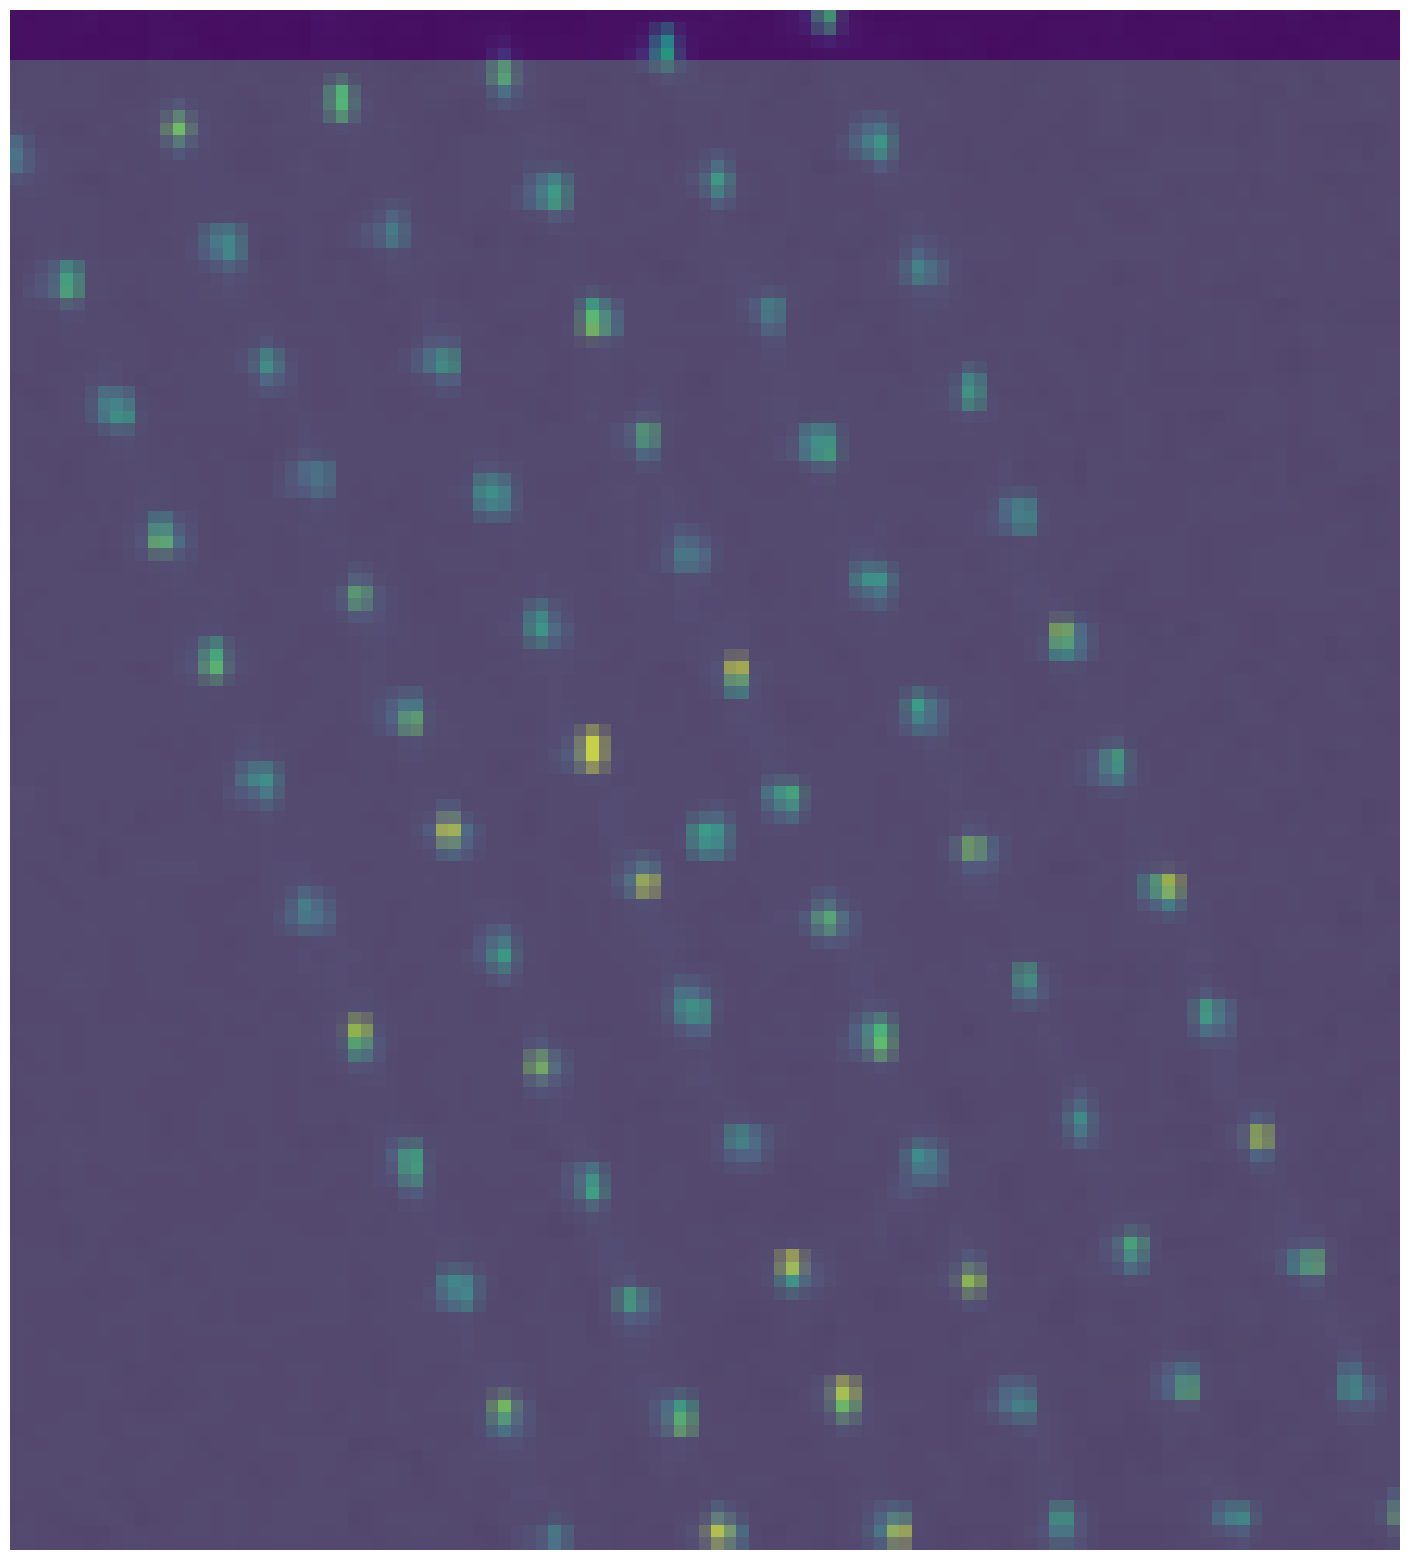

Image cropped and saved successfully!
666 201 495 309


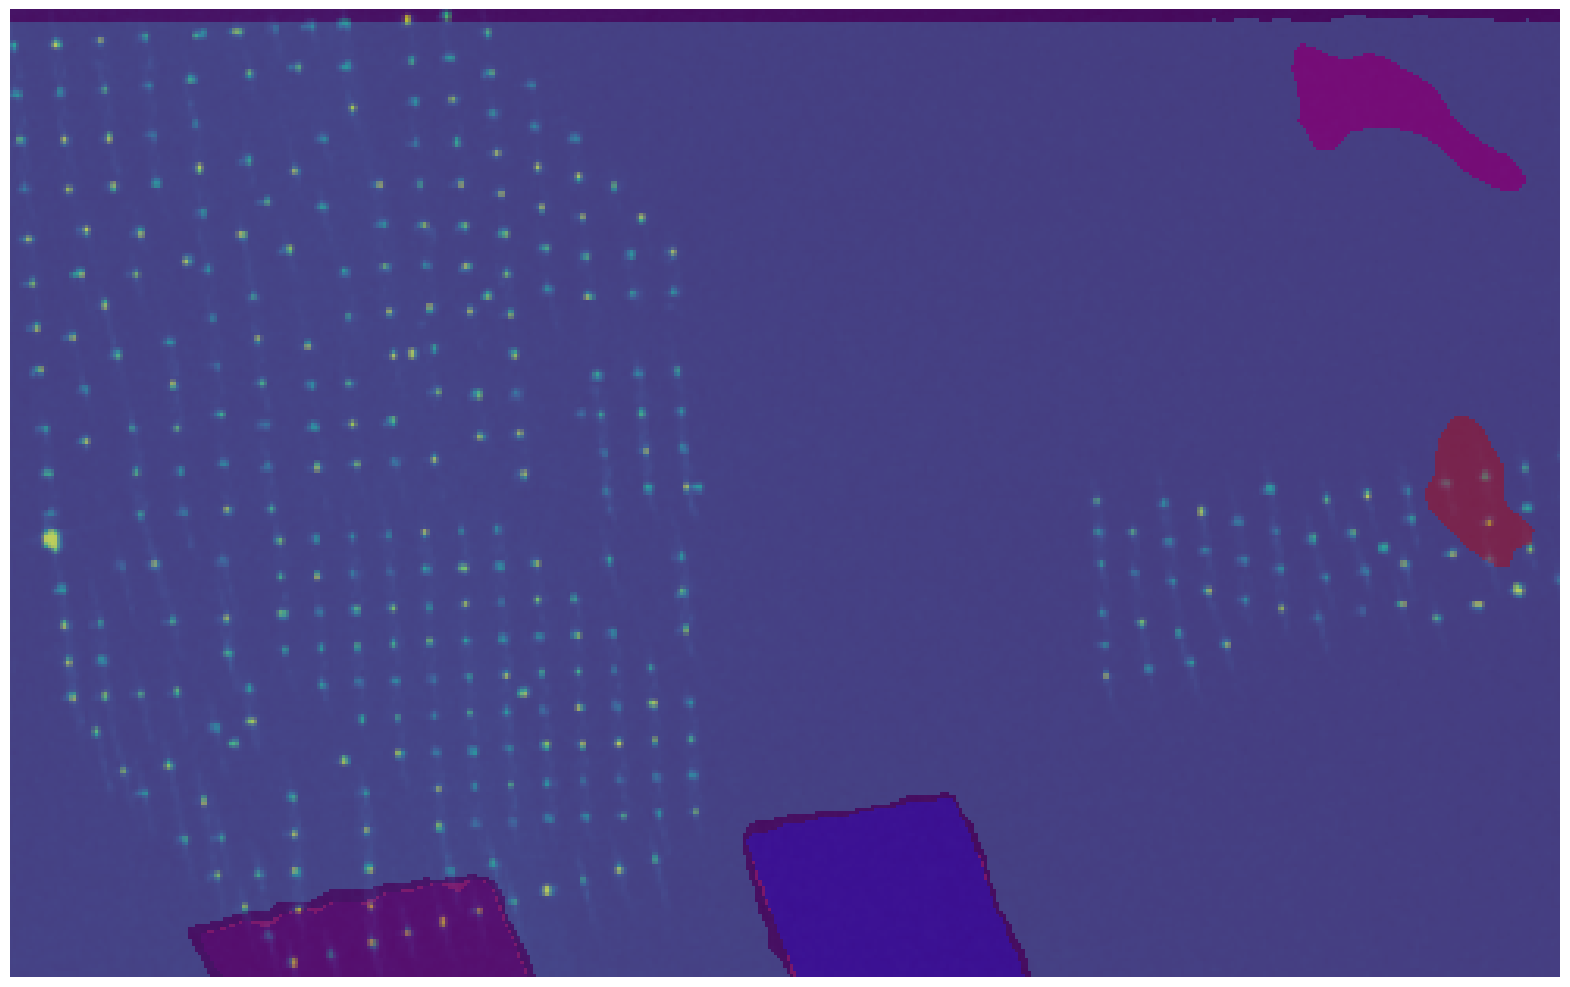

Image cropped and saved successfully!
1201 167 140 202


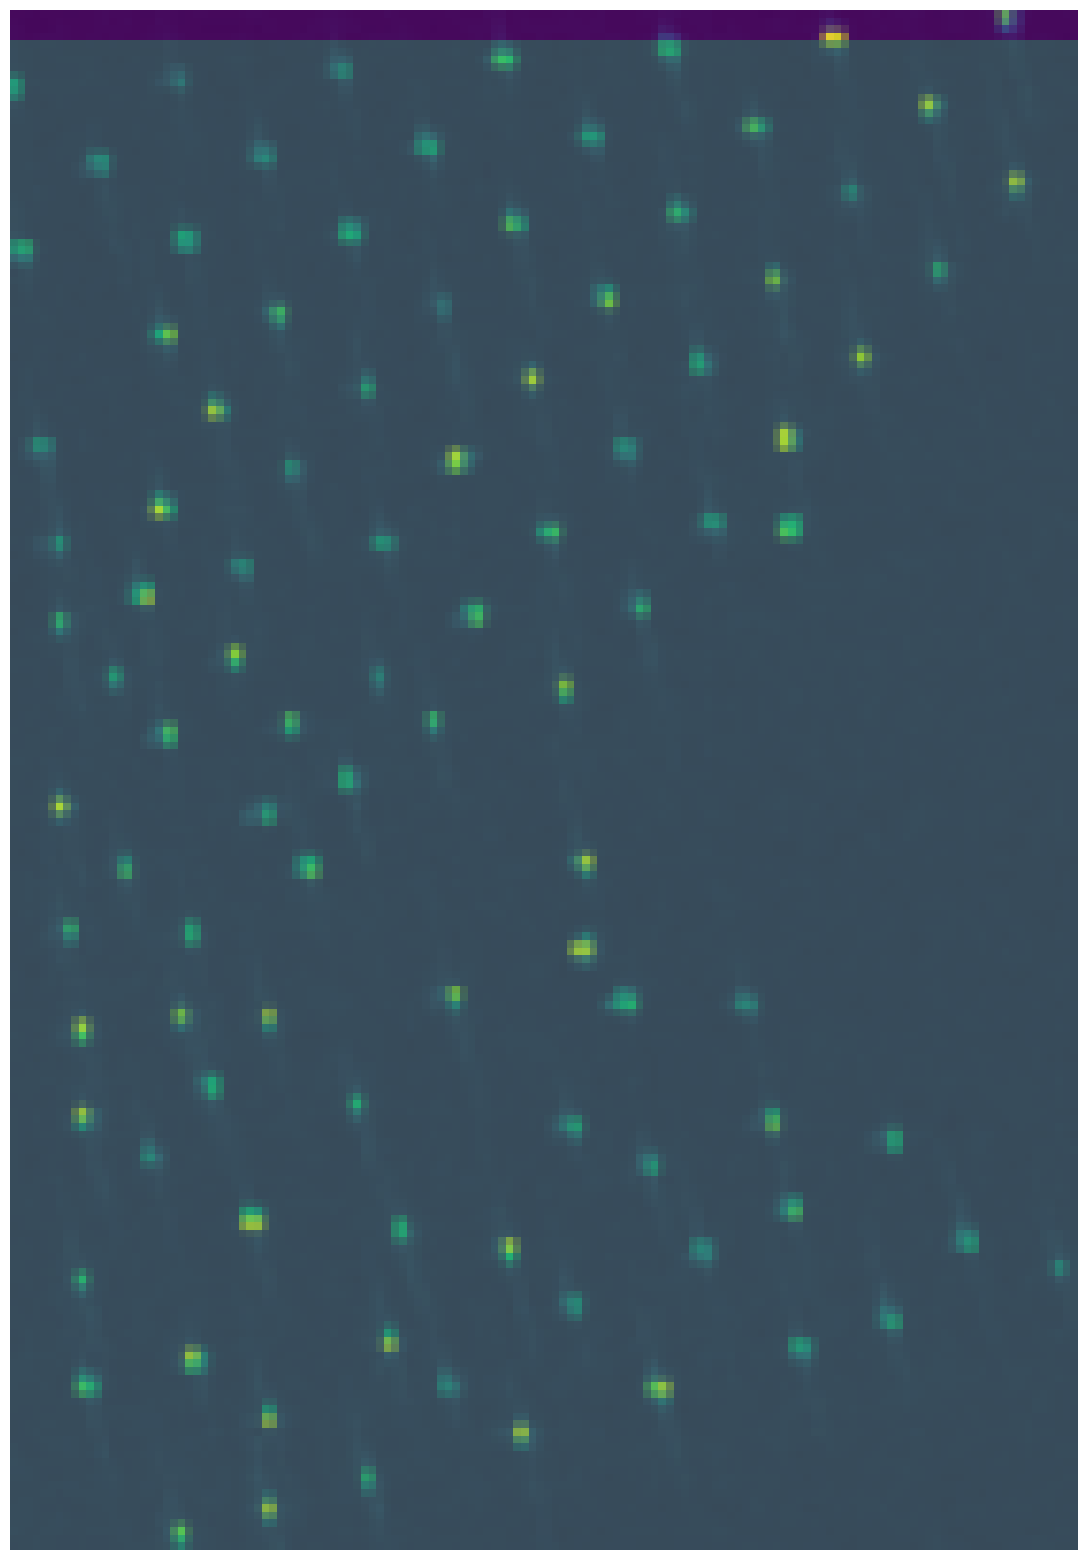

Image cropped and saved successfully!
1011 343 161 72


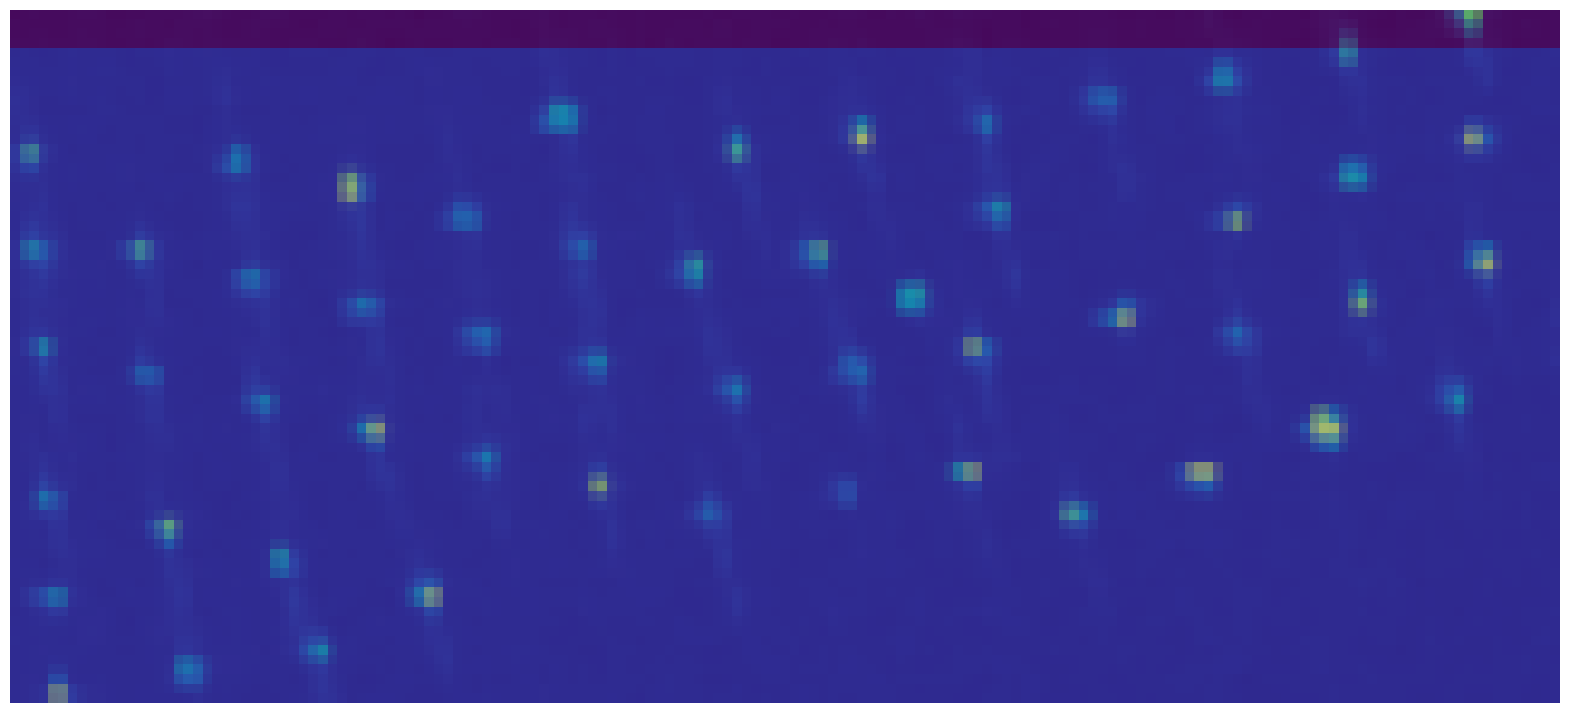

Image cropped and saved successfully!
1010 168 330 247


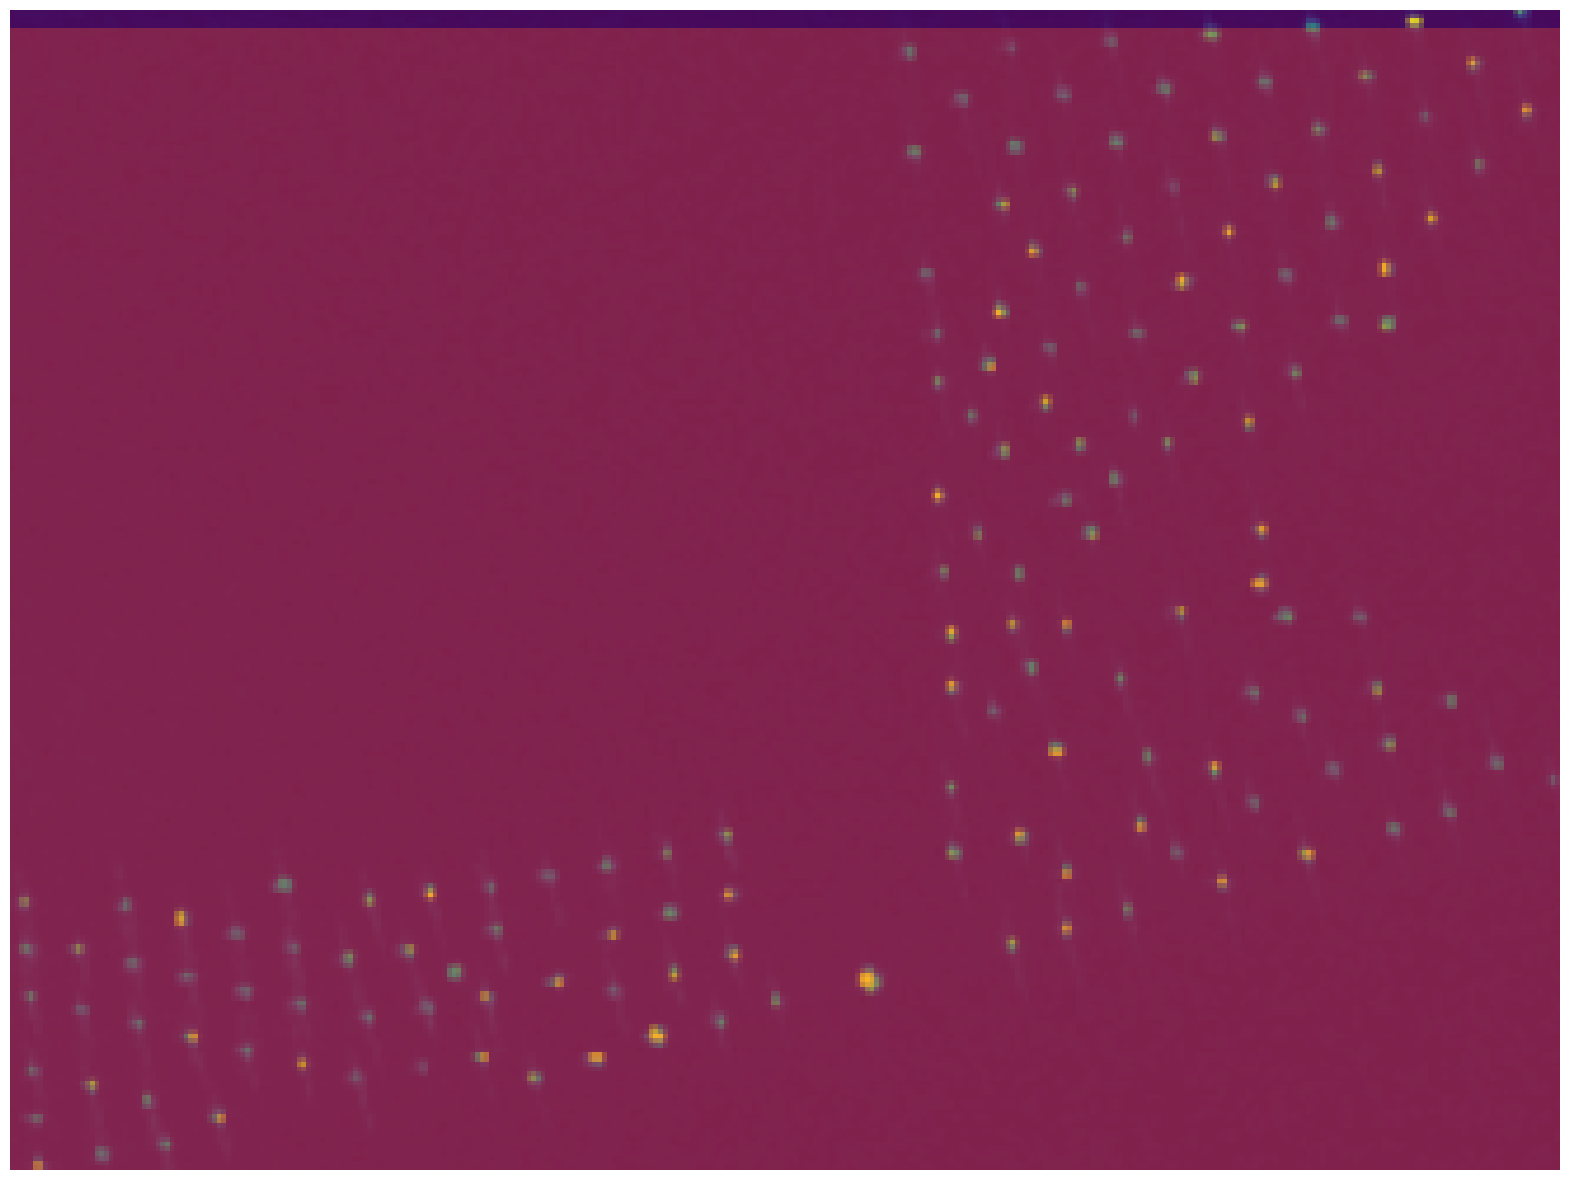

Image cropped and saved successfully!
384 531 42 40


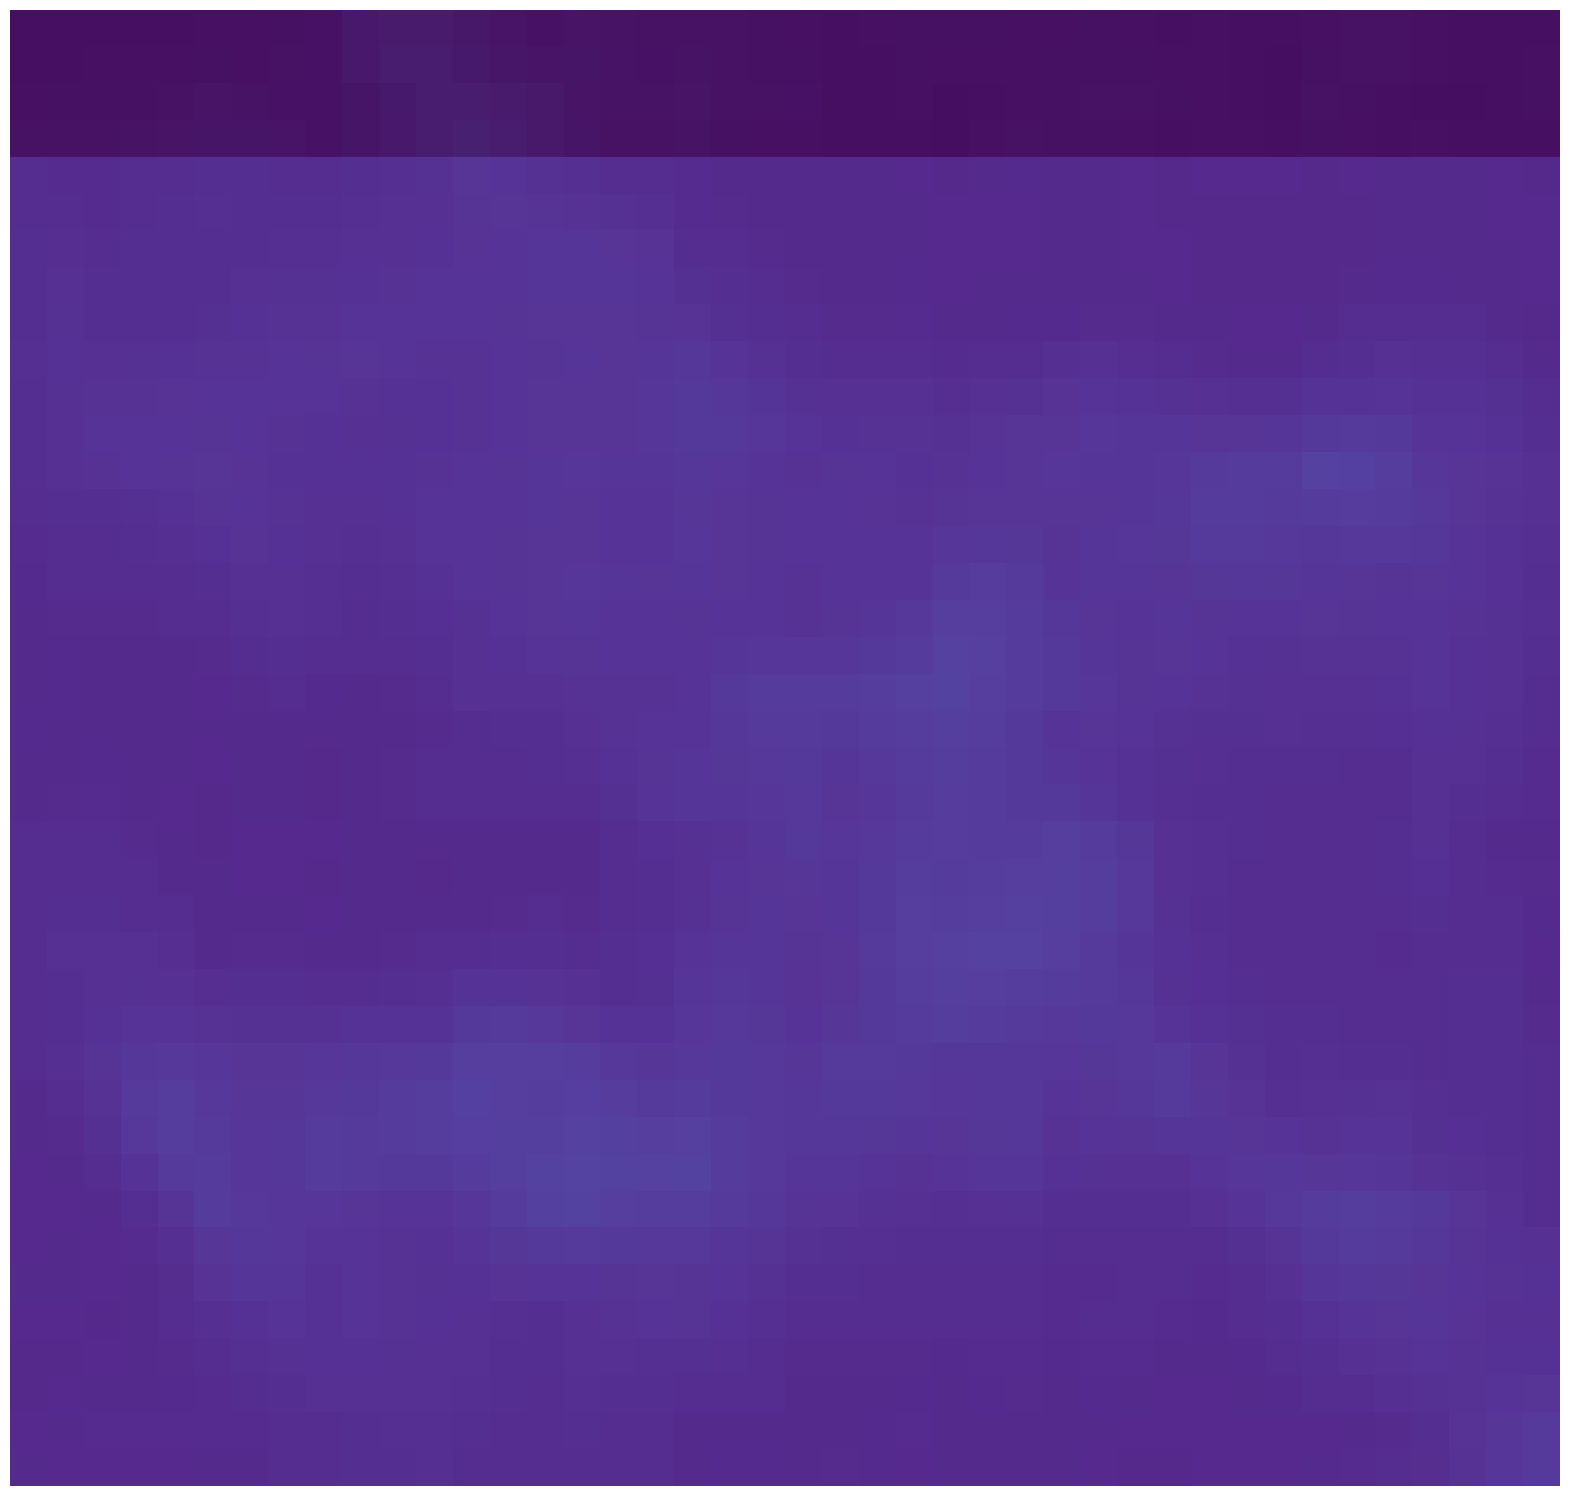

Image cropped and saved successfully!
452 130 34 47


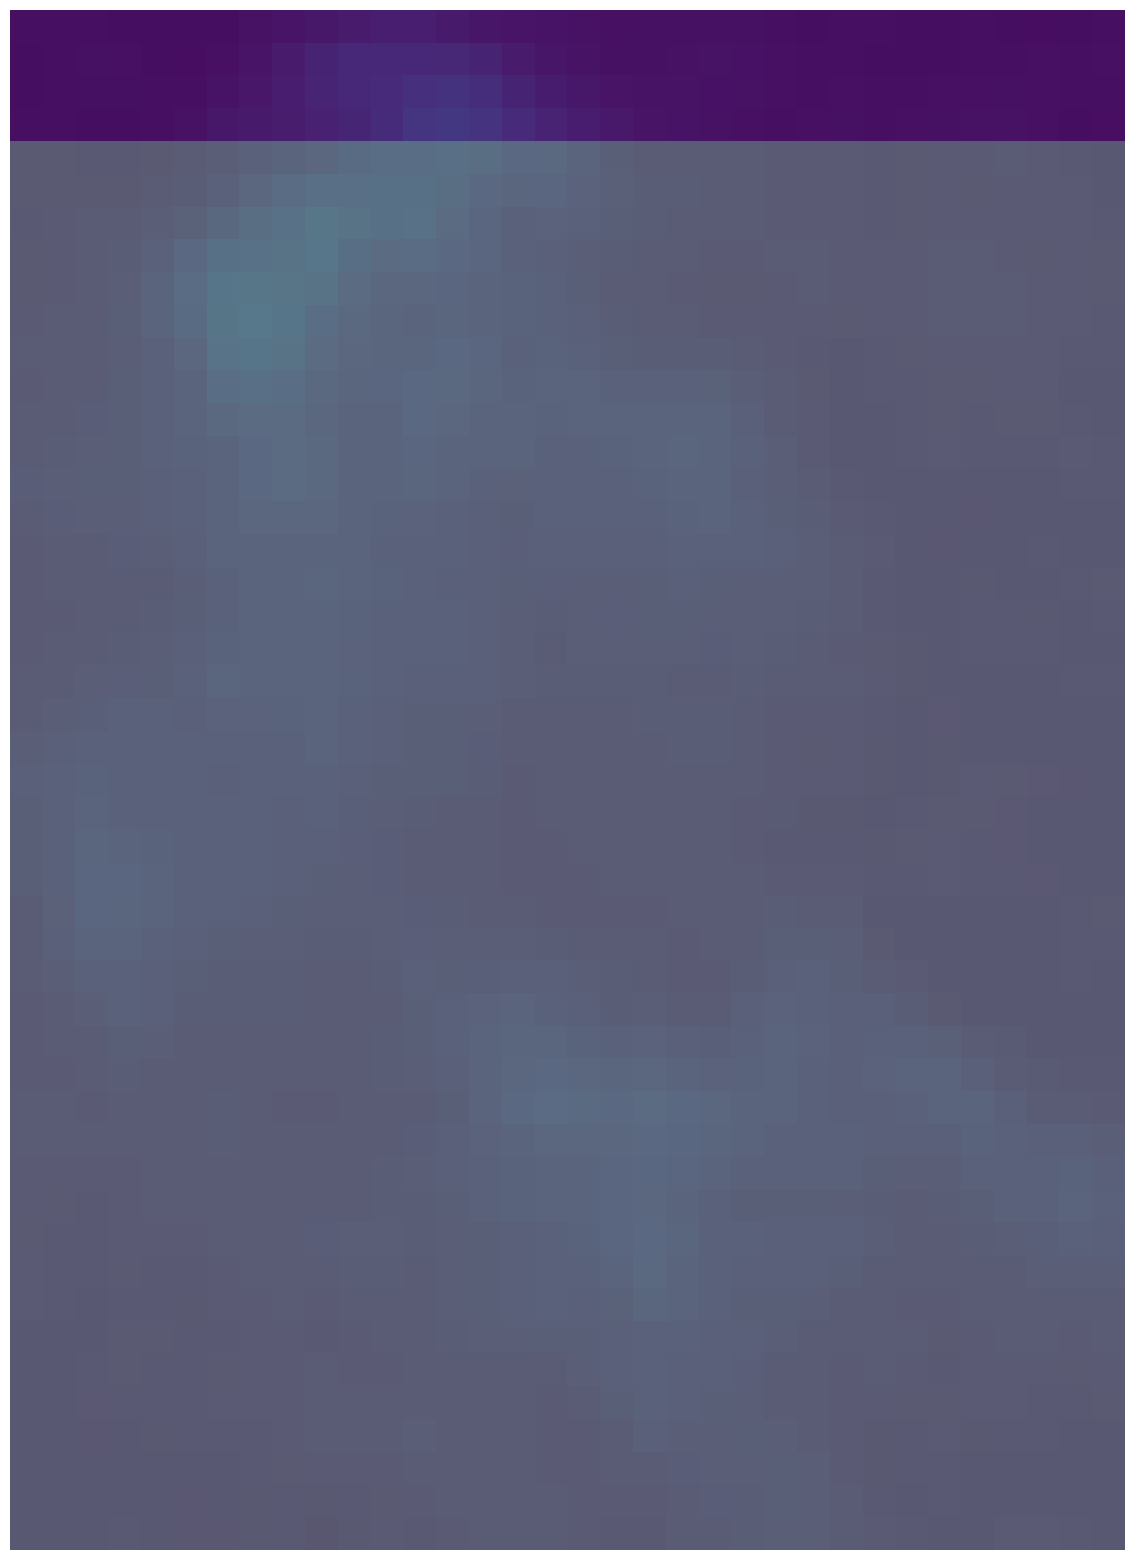

Image cropped and saved successfully!
552 739 6 6


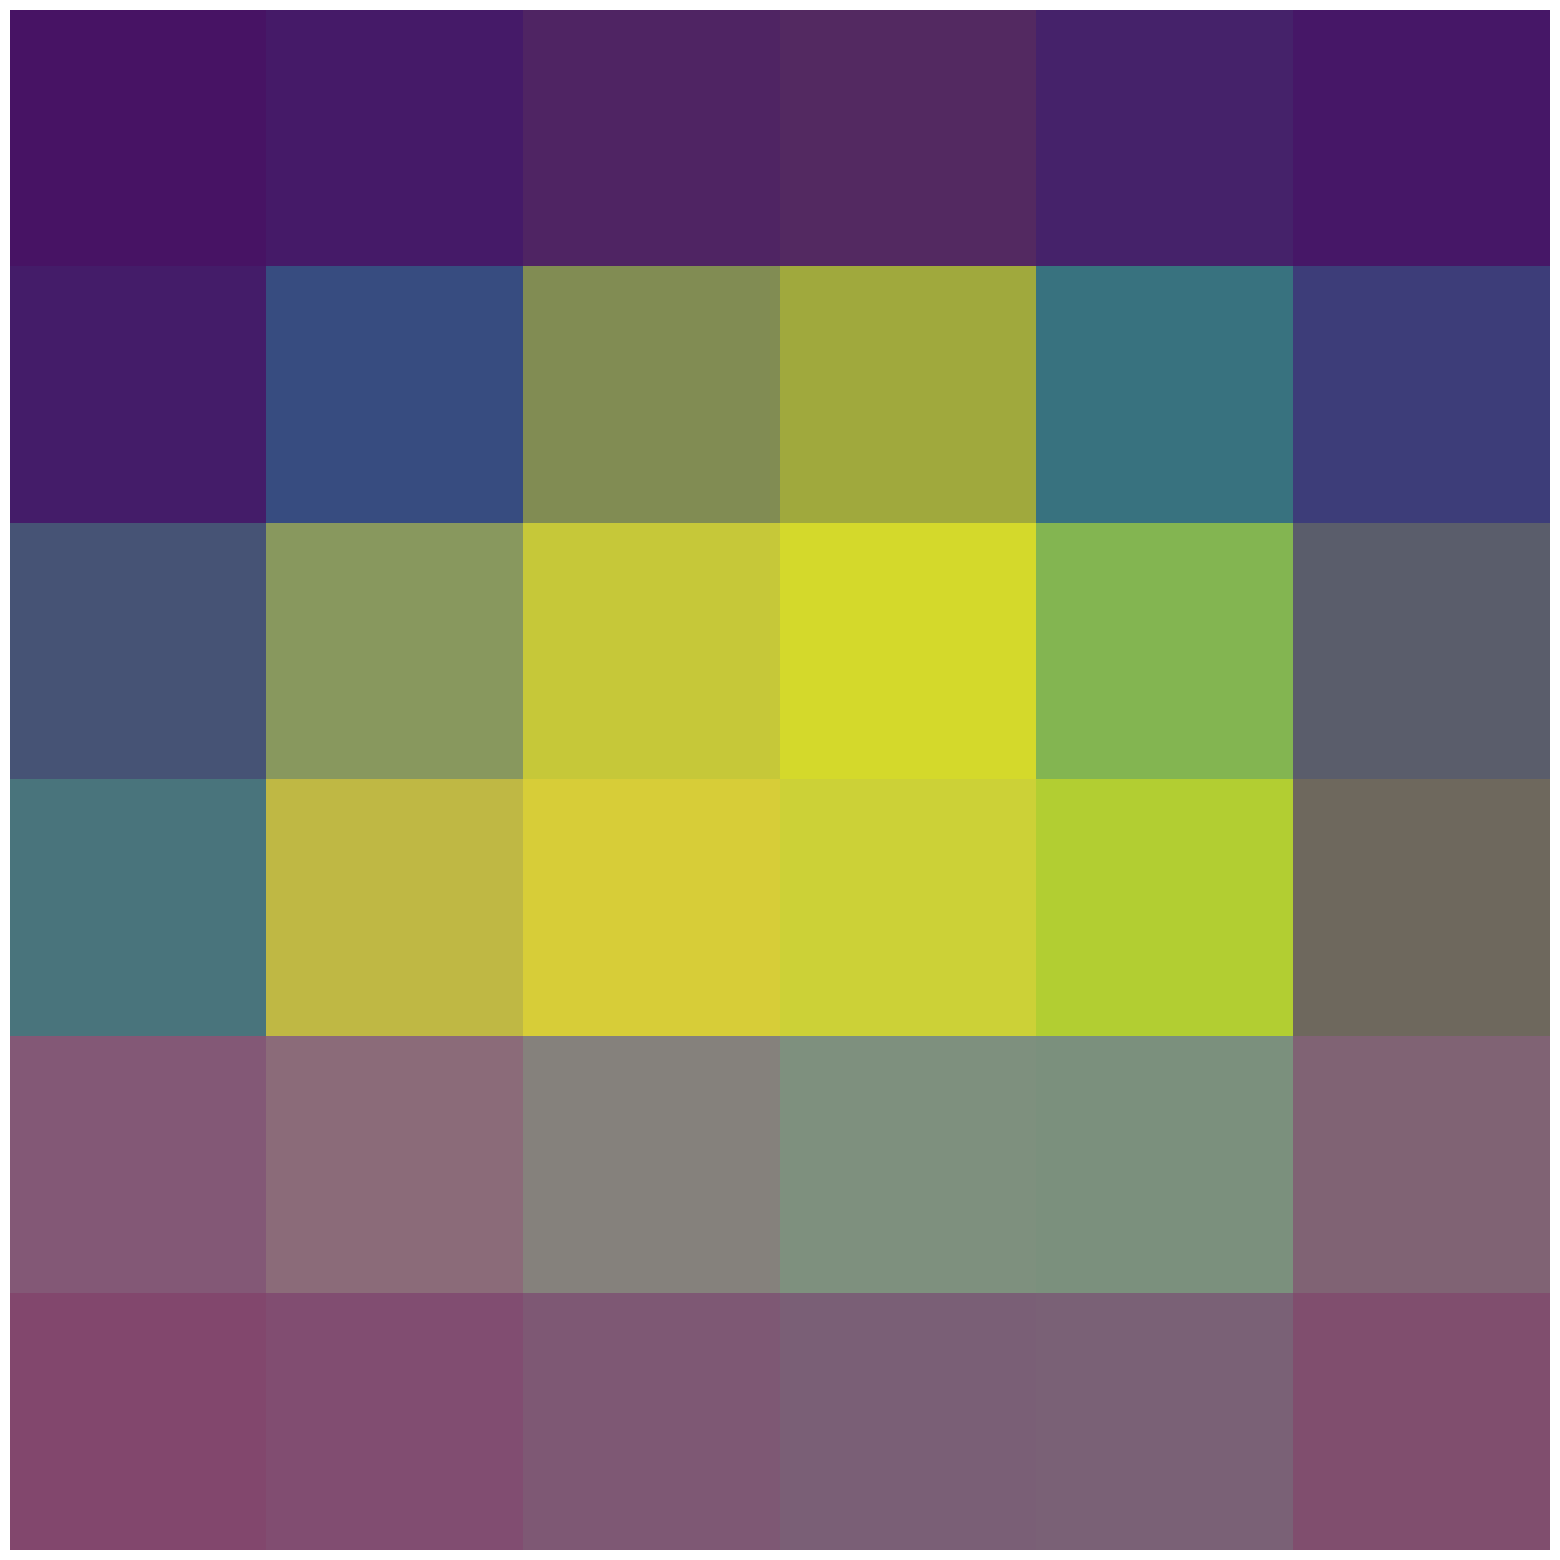

Image cropped and saved successfully!
409 11 74 46


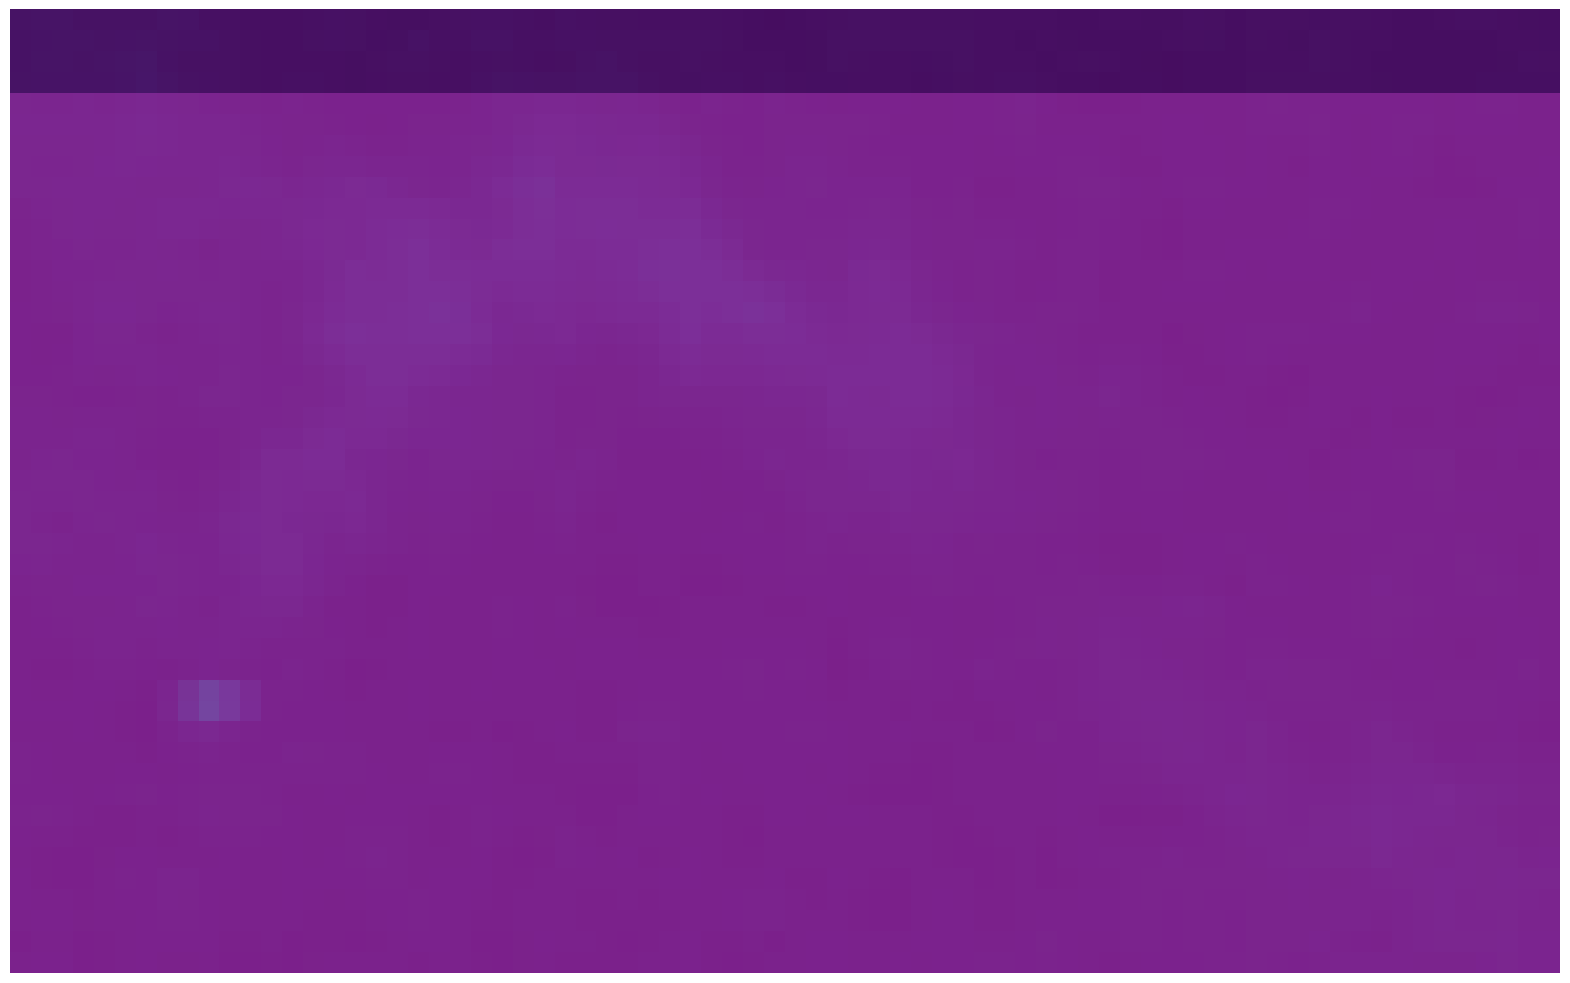

Image cropped and saved successfully!


In [ ]:
from PIL import Image
import numpy as np

def crop_image(image_path, bbox, output_path):
    # Open the image
    image = Image.open(image_path)

    # Extract the bounding box coordinates
    x, y, w, h = bbox

    # Calculate the bottom-right corner coordinates
    x2 = x + w
    y2 = y + h

    # Crop the image based on the bounding box coordinates
    cropped_image = image.crop((x, y, x2, y2))

    # Save the cropped image to the output path
    # cropped_image.save(output_path)
    plt.figure(figsize=(20,20))
    plt.imshow(cropped_image)
    show_anns(masks)
    plt.axis('off')
    plt.show()

    print("Image cropped and saved successfully!")



k = 0
for i, mask in enumerate(masks):
    x1, y1, x2, y2 = mask["bbox"]
    print(x1, y1, x2, y2)
    crop_image("images/vv.png", mask["bbox"], "segments/vv-" + str(k) + ".png")
    k += 1

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

<hr>
Like previously, we are using a pre-saved image of a segmented bounding box here for testing purposes, however, in practice you would loop through the folder of saved segmented images and apply the following mask in all of them
<hr>

In [ ]:
image = cv2.imread('images/vv_segmented.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

The code below essentially controls how many windmills are filtered through by SAM and segmented.

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50, # increased from 32 to 64
    pred_iou_thresh=0.8, # decreased from 0.86 to 0.8
    stability_score_thresh=0.98, # decreased from 0.98 to 0.9
    crop_n_layers=4, # increased from 1 to 2
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

82

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')